# Finer-scale analysis of single genotypes identified in Tilman's gap crossing silencing screen

In [1]:
import scipy.io as sio
from os import mkdir
import numpy as np
from os.path import sep, isdir
from os import mkdir, makedirs, getcwd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrow
from matplotlib import rcParams

from gapCrossingAnalysisFunctions import *

In [2]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

### Match lines to neuron types

In [3]:
E_PG = ['SS90','SS96','SS98','SS131']
EP_G = ['SS2254']
P_EG = ['SS2191']
G_E = ['SS95','SS97','SS130'] # all not clean
P_FN = ['SS007','SS21','SS44','SS78','SS80','SS81', 'SS152', 'SS161','SS191',
        'SS279','SS406','SS425','SS2209','SS2255','SS2303',
       'SS79','SS82','SS87','SS216','SS404','SS418','SS424','SS2244','SS2304','SS2302']# this line annotated by me
P_EN2 = ['SS2232','SS2241']
P_FR = ['SS2270','SS2293']
Ring = ['SS52','SS057','SS72','SS194','SS292','SS293']
FBintern = ['SS33','SS93']
LALPS_P = ['SS2216']
PF_LALCre = ['SS2239']
control = ['FCF']

neuronTypes = {
    'E_PG':E_PG, 
    'EP_G':EP_G,
    'P_EG':P_EG,
    'G_E':G_E,
    'P_EN2':P_EN2,
    'P_FN':P_FN,
    'P_FR':P_FR,
    'Ring':Ring,
    'FBintern':FBintern,
    'LALPS_P':LALPS_P,
    'PF_LALCre':PF_LALCre,
    'control':control
}

# Finer classification of P-FNs:
P_FN1 = []
P_FN2 = []
P_FN3 = ['SS007','SS80', 'SS81','SS406','SS2255']
P_FN4 = ['SS78','SS161']
P_FN5 = ['SS2209']

P_FN1__P_FN2 = ['SS44','SS191','SS279','SS425']
P_FN1__P_FN2__P_FN3 = ['SS2303']
P_FN1__P_FN2__P_FN3__P_FN4__P_SPS = ['SS21']
P_FN4__P_FN5__plus = ['SS152']

PFNtypes = {
    'P_FN3':P_FN3,
    'P_FN4':P_FN4,
    'P_FN5':P_FN5,
    'P_FN1_2':P_FN1__P_FN2,
    'P_FN1_2_3':P_FN1__P_FN2__P_FN3,
    'P_FN1_2_3_4__P_SPS': P_FN1__P_FN2__P_FN3__P_FN4__P_SPS,
    'P_FN4_5__plus': P_FN4__P_FN5__plus
}


#Color codes

nclassCols = {
    '':'silver',
    'E_PG':'m', 
    'EP_G':'plum',
    'P_EG':'hotpink',
    'G_E':'lightpink',
    'P_EN2':'mediumpurple',
    'P_FN':'tomato',
    'P_FR':'deepskyblue',
    'Ring':'mediumblue',
    'FBintern':'lightseagreen',
    'LALPS_P':'yellowgreen',
    'PF_LALCre':'goldenrod',
    'control':'dimgrey'
}

P_FN_cols = {
    'P_FN1':'red', 
    'P_FN2':'firebrick', 
    'P_FN3':'mediumseagreen', 
    'P_FN4':'deepskyblue', 
    'P_FN5':'steelblue', 
    'P_FN1_2':'tomato',
    'P_FN1_2_3':'orchid',
    'P_FN1_2_3_4__P_SPS': 'purple',
    'P_FN4_5__plus': 'mediumblue'
}

## Load pre-processed data (dataGC.mat)
#### Data assumed to be located in ../../Data/ folder relative to code directory, plots will be saved in ../Plots/

In [4]:
parentDir = sep.join(getcwd().split(sep)[:-2])
dataDir = parentDir+sep+'Data'
print(dataDir)

/Users/haberkernh/Desktop/GapCrossing/Data


In [5]:
plotDir = sep.join(getcwd().split(sep)[:-1]+['Plots'+sep+'fineScaleAnalysis'])
print(plotDir)
if not isdir(plotDir):
    mkdir(plotDir)

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/fineScaleAnalysis


In [6]:
matstruct = sio.loadmat(dataDir+sep+'dataGC.mat')
matdata = matstruct['dataGC']
matdata = matdata[:-3]
ngts = len(matdata)
genotypedata = matdata[0][0]

## Illustrate behavioural phenotypes using some example genotypes
#### *Note: At the moment data from climbing events with missing meta data (gap size, fly id) are ommitted.*
### (a) Vector plot

In [7]:
def compareGenotypes_vecPlot(genotypeslct, gapsizes, cols):
    fig, axs = plt.subplots(len(gapsizes)+1,len(genotypeslct), figsize=(15,3*len(gapsizes)))

    for g, gapsize in enumerate(np.hstack((-1,gapsizes))):
        for i, genotype in enumerate(genotypeslct):
            genotypedata = matdata[genotype][0]

            plotClimbingVector(genotypedata, axs[g, i], gapsize, cols[i])
            if g == 0:
                axs[g, i].set_title(genotypedata[0][0])
                reducedAxis(axs[g, i], [-5.5,3,4], 'mm')
            else:
                reducedAxis(axs[g, i], [-5.5,gapsize,4], 'mm')
            axs[g, i].set_xlim(-5, 8)
            axs[g, i].set_ylim(-7, 3)

        if g == 0:
            axs[g, 0].text(-6,-6.5,'all gap sizes')
        else:
            axs[g, 0].text(-6,-6.5,'gap size {}mm'.format(gapsize))
            
    return fig

### (b) Distribution of body orientations during climps and (c) fraction of "off-target" climbs

In [8]:
# Define a cutoff angle for "off-target climbing events"
offtarget_ang = 50

In [9]:
def compareGenotypes_offTag(genotypeslct, cols):
    fig, axs = plt.subplots(1,2, figsize=(10,4), gridspec_kw={'width_ratios':[2,1]})

    offtarget_attempts = np.zeros(len(genotypeslct))
    n = np.zeros(len(genotypeslct))
    for i, genotype in enumerate(genotypeslct):
        genotypedata = matdata[genotype][0]
        print('{}, n={}'.format(genotypedata[0][0],len(genotypedata[5])))
        n[i] = len(genotypedata[5])

        axs[0].hist(genotypedata[7], range=(-180, 180), density=True, histtype='step',
                    bins=36, linewidth=2, label='', alpha=0.8, color=cols[i])
        axs[0].hist(genotypedata[7], range=(-180, 180), density=True, histtype='step',
                    bins=36, linewidth=0, alpha=0.25, color=cols[i],
                    fill=cols[i], label=genotypedata[0][0])

        clang = genotypedata[7]
        offtarget_attempts[i] = 100*(sum(abs(clang)>offtarget_ang)/len(clang))

    axs[1].bar(np.arange(len(genotypeslct)), offtarget_attempts, 0.7, color=cols, alpha=0.8)
    plt.xticks(np.arange(len(genotypeslct)), 
               [matdata[genotype][0][0][0] for genotype in genotypeslct],fontsize=12, rotation=30)

    axs[0].legend()
    axs[0].set_xlabel('Climbing angle [deg]', fontsize=12)
    axs[0].set_ylabel('Frequency', fontsize=12)
    axs[0].set_title('Distribution of climbing directions\n(0 deg = head on)', fontsize=12)

    axs[1].set_title('Fraction off-target (>{} deg)\nclimbing attempts'.format(offtarget_ang), fontsize=12)
    axs[1].set_ylim(0,40)
    for i in range(len(genotypeslct)):
        axs[1].text(i-(len(genotypeslct)*0.05), offtarget_attempts[i] + .25, str(int(n[i])), fontsize=12)
    
    for ax in axs:
        myAxisTheme(ax)
    fig.tight_layout() 
    return fig

### (c) Distance from edge quantified by x-position of abdomen at (beginning of) climb event

In [10]:
def compareGenotypes_dist(genotypeslct, gapsizes, cols, medcol):
    fig, axs = plt.subplots(1,len(gapsizes)+1,figsize=(10,3+0.5*len(gapsizes)))

    for g, gapsize in enumerate(np.hstack((-1,gapsizes))):
        for i, genotype in enumerate(genotypeslct):
            genotypedata = matdata[genotype][0]
            gs = list(np.squeeze(np.asarray(genotypedata[8])))

            if gapsize < 0:
                mask = np.arange(len(gs))
            else:
                mask = np.where(gs == gapsize)[0]

            #select data of from experiment with correct gap size
            xa = np.squeeze(np.asarray(genotypedata[3]))[mask]
            xh = np.squeeze(np.asarray(genotypedata[4]))[mask]

            med = np.median(xa)
            jitter = np.random.rand(len(xa))*1.5
            offset = 3*i+1
            axs[g].plot(xa,1+3*i*np.ones(len(xa))+jitter, '.', color=cols[i],alpha=0.8)
            axs[g].plot([med,med],[offset, offset+1.5],medcol,linewidth=3)

            if g == 0:
                axs[g].text(4, offset, genotypedata[0][0])

        if g == 0:
            reducedAxis(axs[g], [-5.5,3,4], 'mm')
        else:
            reducedAxis(axs[g], [-5.5,gapsize,4], 'mm')
        drawBlock(axs[g], gapsize)
        axs[g].set_xlim(-8, 8)
        axs[g].set_ylim(-1, len(genotypeslct))
        axs[g].plot([0,0],[0,offset+3], color='black', linestyle='dashed', linewidth=0.5)

        if g == 0:
            axs[g].text(-6,-6,'all gap sizes')
        else:
            axs[g].text(-6,-6,'gap size {}mm'.format(gapsize))
    fig.tight_layout()
    return fig

## Visualisations for pooled data

In [45]:
plotDir = sep.join(getcwd().split(sep)[:-1]+['Plots', 'singleGenotypes'])
print(plotDir)
if not isdir(plotDir):
    mkdir(plotDir)

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/singleGenotypes


In [51]:
def pooledGentoypePlots(genotypeslct, cols, medcol, genname):
    
    # make plot directory
    currPlotDir = sep.join([plotDir, genname])
    print(currPlotDir)
    if not isdir(currPlotDir):
        mkdir(currPlotDir)
        
    
    # find gap sizes
    gapsizes = []
    for i, genotype in enumerate(genotypeslct[:]):
        genotypedata = matdata[genotype][0]
        gapsizes +=(list(set(genotypedata[8][~np.isnan(genotypedata[8])].flatten())))
    gapsizes = list(set(gapsizes))

    # plot results
    fig = compareGenotypes_vecPlot(genotypeslct, gapsizes, cols)
    fig.savefig(currPlotDir+sep+genname+'_vecPlot.pdf')

    fig = compareGenotypes_offTag(genotypeslct, cols)
    fig.savefig(currPlotDir+sep+genname+'_offTagPlot.pdf')

    fig = compareGenotypes_dist(genotypeslct, gapsizes, cols, medcol)
    fig.savefig(currPlotDir+sep+genname+'_distPlot.pdf')

### Controls

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/singleGenotypes/controls
FCF_TNT, n=128
FCF_DLS, n=73
FCF_SHI, n=113


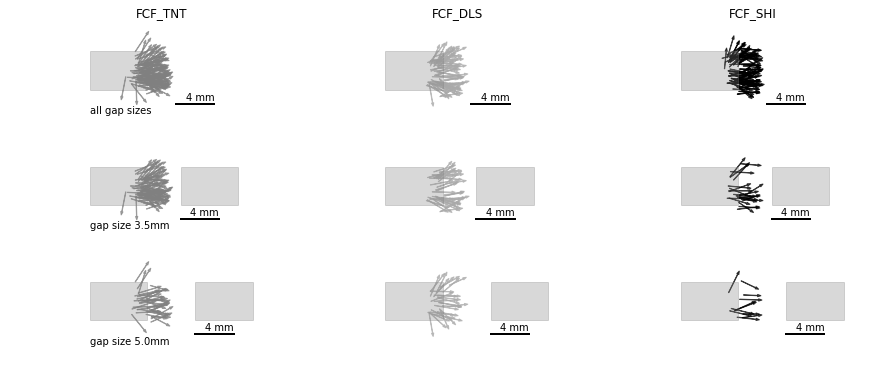

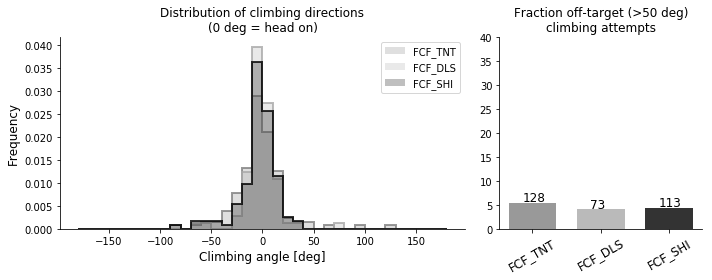

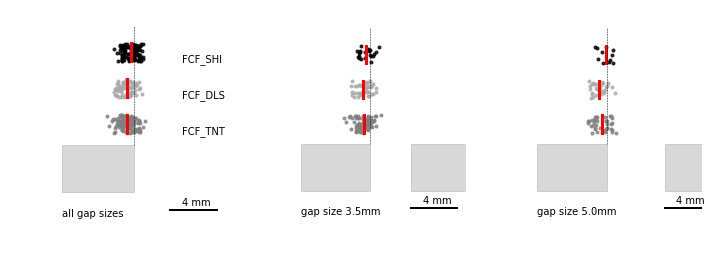

In [52]:
genotypeslct = [2,1,0]
cols = ['grey', 'darkgrey','black']
medcol = 'red'
genname = 'controls'

pooledGentoypePlots(genotypeslct, cols, medcol, genname)

### E-PGs

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/singleGenotypes/EPGs_TNT
FCF_TNT, n=128
SS90_TNT, n=74
SS96_TNT, n=80
SS98_TNT, n=136


/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


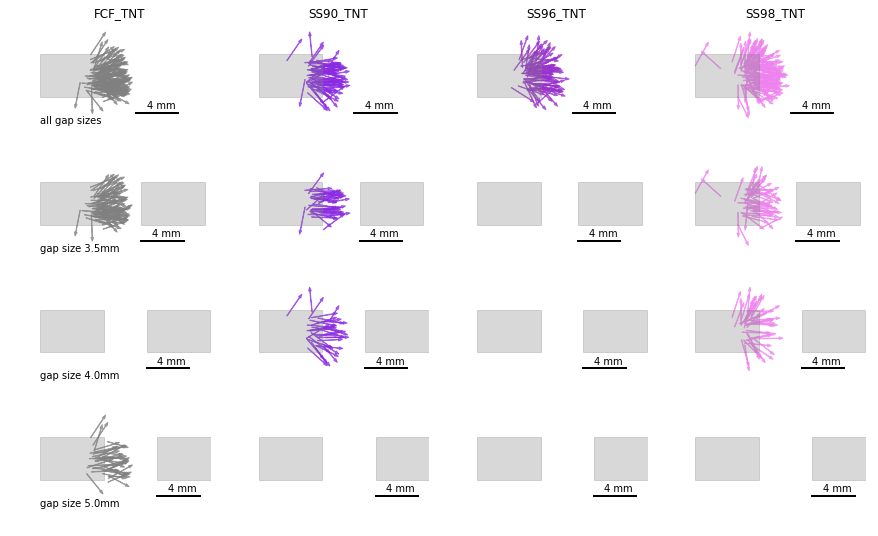

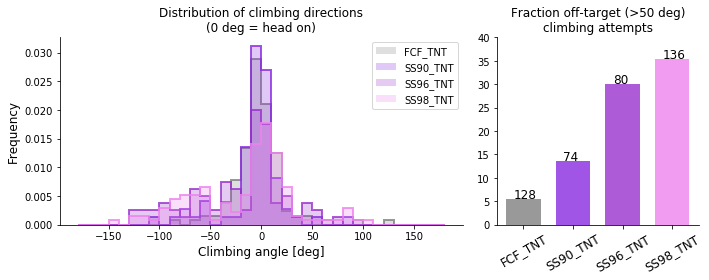

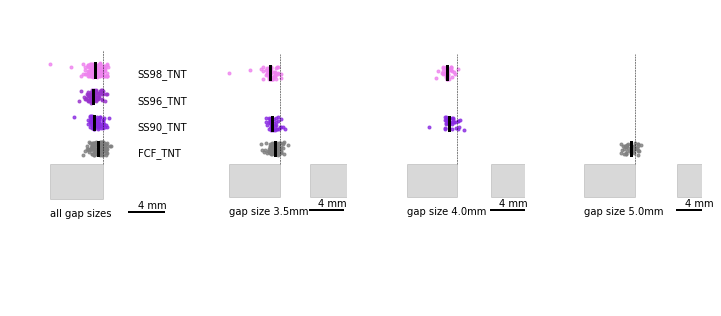

In [53]:
EPG_tnt = [2] + [30, 36, 40]
EPG_dls = [1] + [29, 35, 38]
EPG_shi = [0] + [39]

genotypeslct =  EPG_tnt
cols = ['grey', 'blueviolet', 'darkorchid','violet']#, 'dimgrey', 'blueviolet', 'darkorchid']#
medcol = 'black'

genname = 'EPGs_TNT'

pooledGentoypePlots(genotypeslct, cols, medcol, genname)

### P-FNs
#### P-FN1&2

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/singleGenotypes/PFN1_2_dls
FCF_DLS, n=73
SS44_DLS, n=81
SS191_DLS, n=71
SS425_DLS, n=57


/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


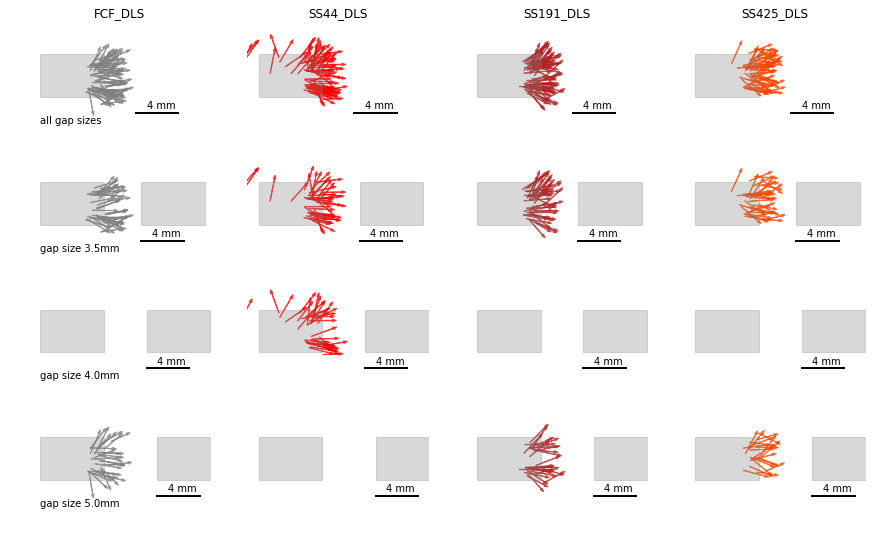

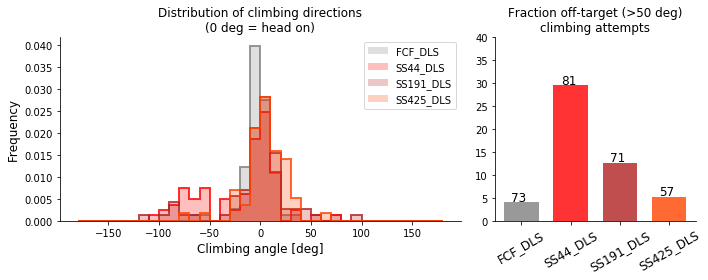

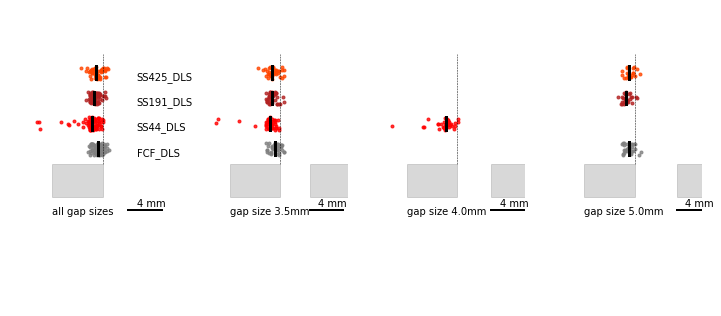

In [60]:
PFN12_tnt = [2] + [59, 68]
PFN12_dls = [1] + [10, 57, 80]
PFN12_shi = [0] + [58, 67]

genotypeslct =  PFN12_dls
genname = 'PFN1_2_dls'
cols = ['grey', 'red', 'firebrick', 'orangered']
medcol = 'black'

pooledGentoypePlots(genotypeslct, cols, medcol, genname)

#### P-FN3

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/singleGenotypes/PFN3_DLS
FCF_DLS, n=73
SS007_DLS, n=47
SS80_DLS, n=77
SS81_DLS, n=99
SS406_DLS, n=32
SS2255_DLS, n=71


/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


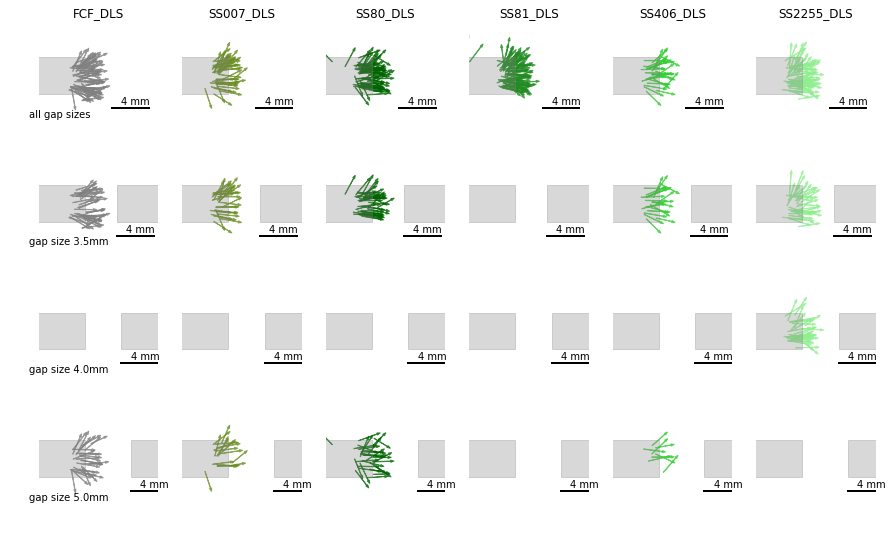

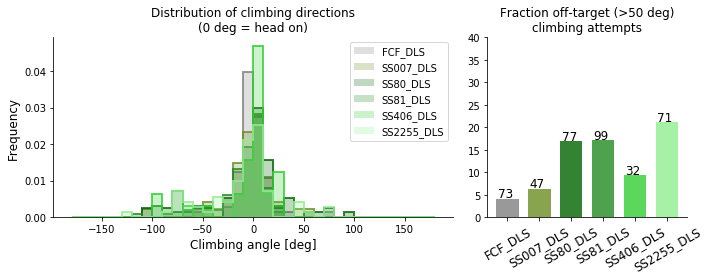

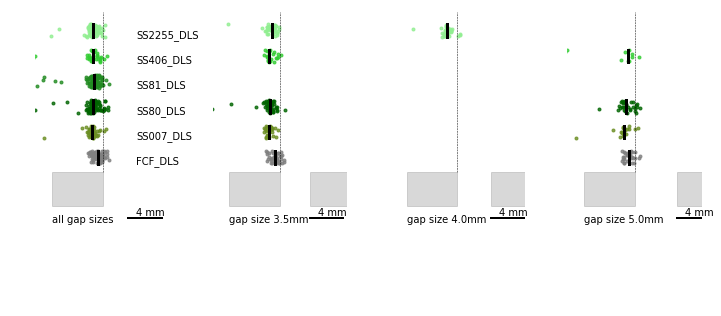

In [72]:
PFN3_tnt = [2] + [25, 76]
PFN3_dls = [1] + [3, 24, 26, 75, 100]
PFN3_shi = [0] + []

genotypeslct =  PFN3_dls
genname = 'PFN3_DLS'
cols = ['grey', 'olivedrab','darkgreen', 'forestgreen', 'limegreen', 'lightgreen']
medcol = 'black'

pooledGentoypePlots(genotypeslct, cols, medcol, genname)

#### P-FN4

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/singleGenotypes/PFN4_TNT
FCF_TNT, n=128
SS78_TNT, n=81
SS161_TNT, n=38


/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


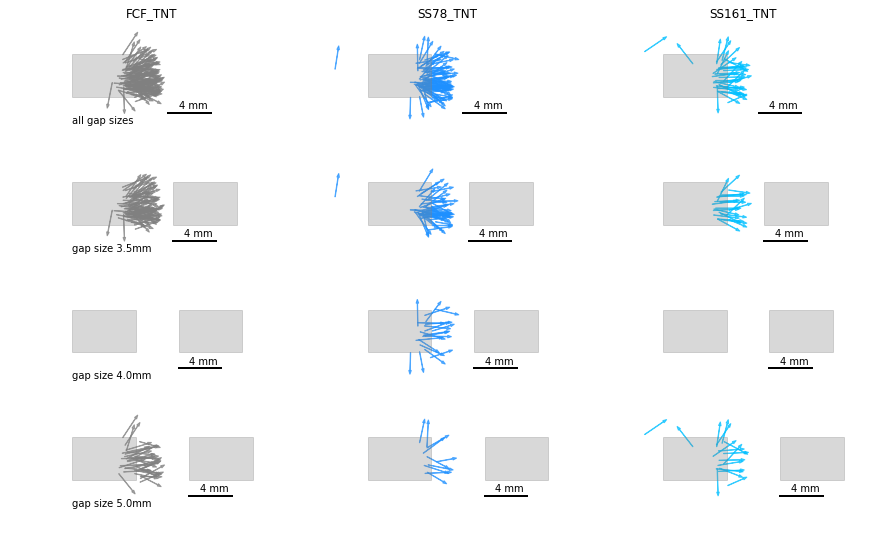

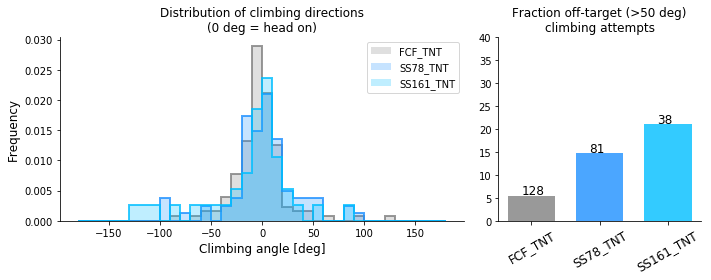

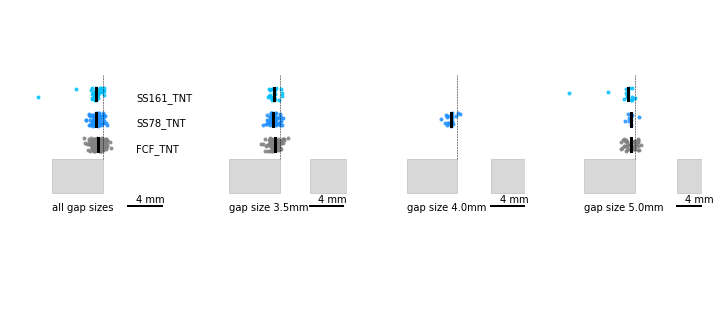

In [77]:
PFN4_tnt = [2] + [22, 53]
PFN4_dls = [1] + [21]
PFN4_shi = [0] + [20, 52]

genotypeslct =  PFN4_tnt
genname = 'PFN4_TNT'
cols = ['grey', 'dodgerblue', 'deepskyblue']
medcol = 'black'

pooledGentoypePlots(genotypeslct, cols, medcol, genname)

#### P-FN5

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/singleGenotypes/PFN5_DLS
FCF_DLS, n=73
SS2209_DLS, n=58


/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


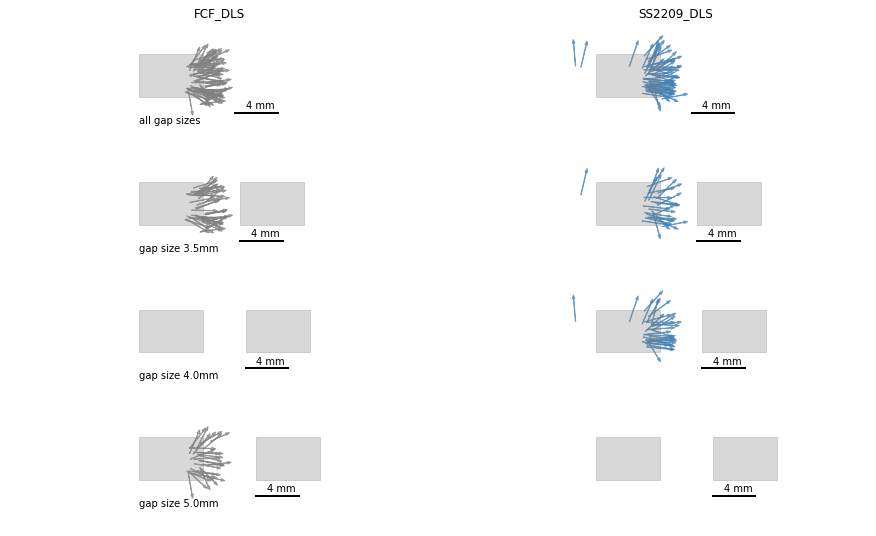

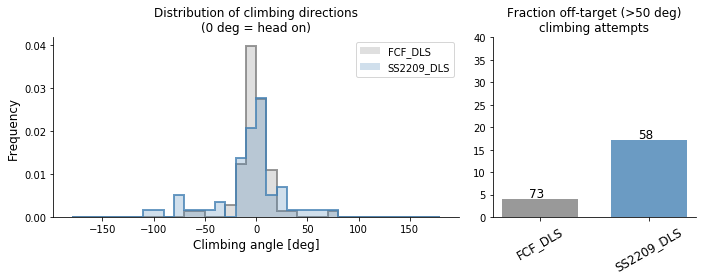

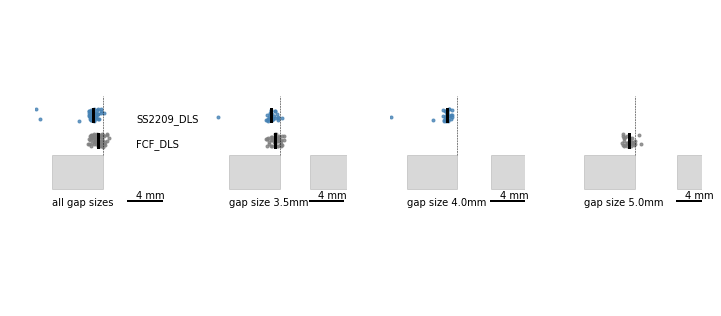

In [79]:
PFN5_tnt = [2] + []
PFN5_dls = [1] + [88]
PFN5_shi = [0] + []

genotypeslct =  PFN5_dls
genname = 'PFN5_DLS'
cols = ['grey','steelblue']
medcol = 'black'

pooledGentoypePlots(genotypeslct, cols, medcol, genname)

### P-FRob

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/singleGenotypes/PFR_TNT
FCF_TNT, n=128
SS2270_TNT, n=97
SS2293_TNT, n=61


/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


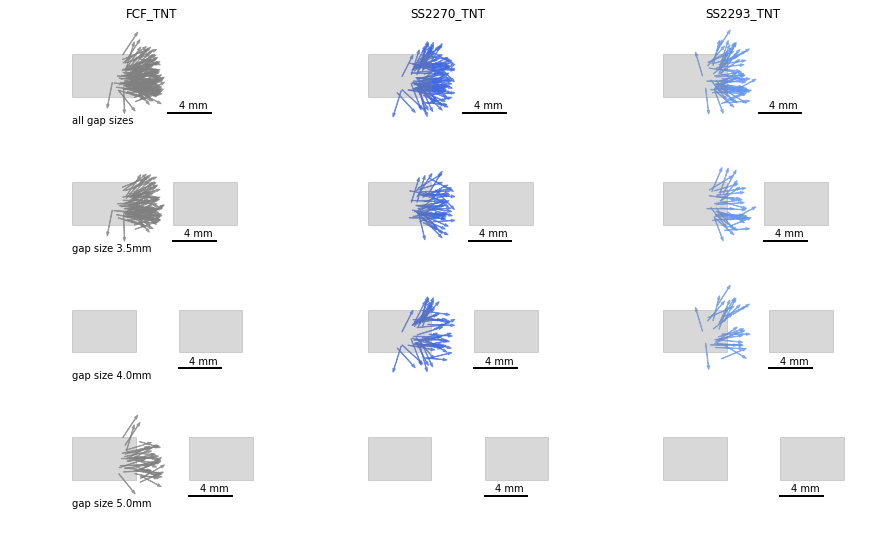

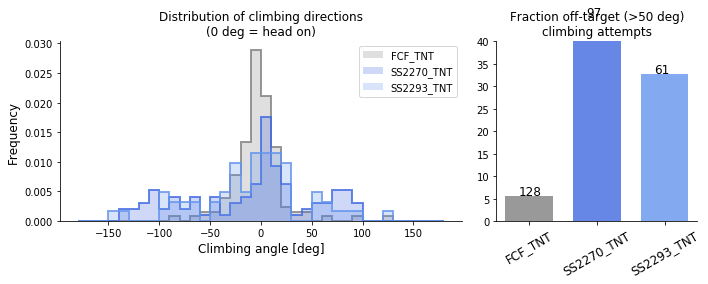

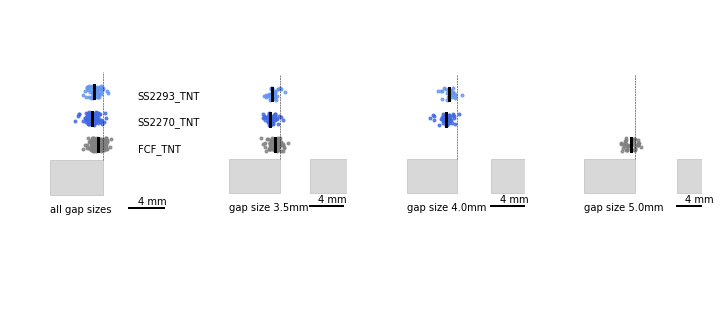

In [81]:
PFR_tnt = [2] + [102, 105]
PFR_dls = [1] + [101]
PFR_shi = [0] + []

genotypeslct =  PFR_tnt
genname = 'PFR_TNT'
cols = ['grey', 'royalblue', 'cornflowerblue']
medcol = 'black'

pooledGentoypePlots(genotypeslct, cols, medcol, genname)

### FB lines

/Users/haberkernh/Desktop/GapCrossing/Analysis/Plots/singleGenotypes/FBdelta
FCF_TNT, n=128
SS93_TNT, n=74
FCF_DLS, n=73
SS93_DLS, n=71
FCF_SHI, n=113
SS93_SHI, n=96


/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


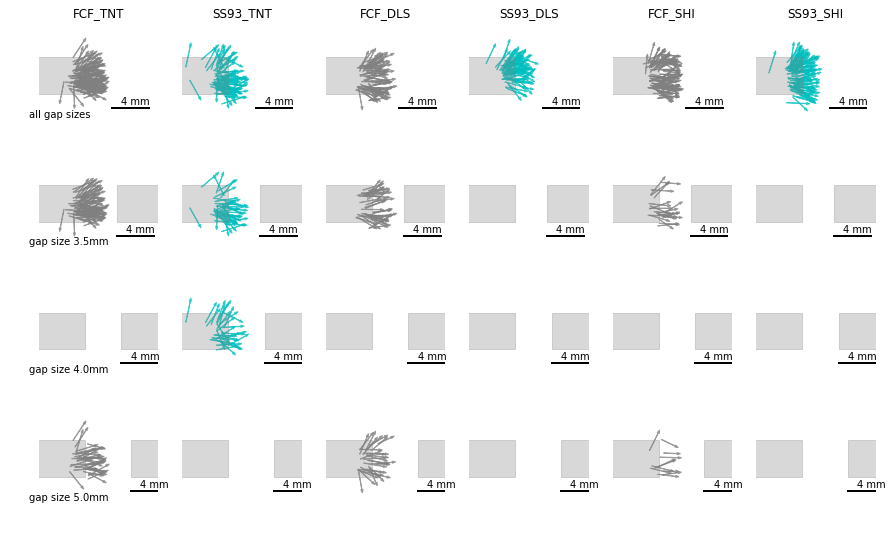

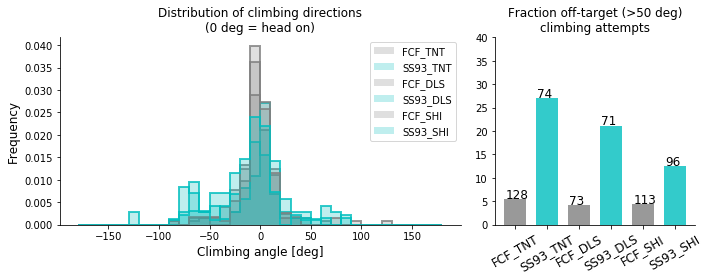

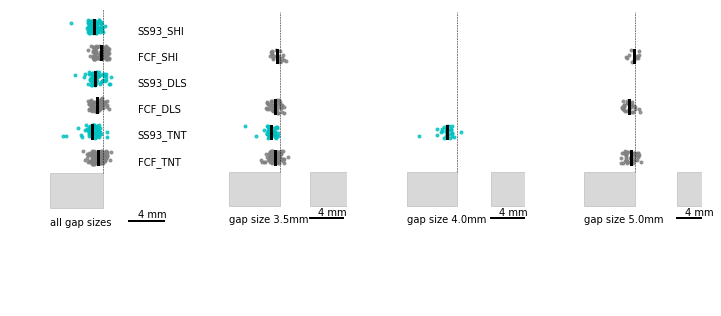

In [83]:
FBdelta_tnt = [2] + [33]
FBdelta_dls = [1] + [31]
FBdelta_shi = [0] + [32]

genotypeslct =  FBdelta_tnt + FBdelta_dls + FBdelta_shi
genname = 'FBdelta'
cols = ['grey', 'c','grey', 'c','grey', 'c']
medcol = 'black'

pooledGentoypePlots(genotypeslct, cols, medcol, genname)

### Compare across flies within single line

In [84]:
import pandas as pd

screenRawdf = pd.DataFrame()
keylist = ['genotype','driver','effector','ax','ay', 'hx', 'hy','angle', 'gap', 'fly'] 
for i in range(ngts):
    genotypedata = matdata[i][0]
    singleFlydf = pd.DataFrame({
        'genotype': genotypedata[0][0],
        'driver': genotypedata[1][0],
        'effector': genotypedata[2][0],
        'ax': list(np.squeeze(np.asarray(genotypedata[3]))),
        'ay': list(np.squeeze(np.asarray(genotypedata[5]))),
        'hx': list(np.squeeze(np.asarray(genotypedata[4]))),
        'hy': list(np.squeeze(np.asarray(genotypedata[6]))),
        'angle': list(np.squeeze(np.asarray(genotypedata[7]))), 
        'gap': list(np.squeeze(np.asarray(genotypedata[8]))),
        'fly': list(np.squeeze(np.asarray(genotypedata[9])))
    })
    screenRawdf = screenRawdf.append(singleFlydf)
screenRawdf = screenRawdf[keylist]

In [212]:
gapsizes = [3.5, 4, 5]

driverList = ['FCF', 'SS90', 'SS96', 'SS98', 'SS131'] #['FCF', 'SS2270']
gennameList = ['Control', 'E-PG1', 'E-PG2', 'E-PG3', 'E-PG4'] #['Control', 'PFRob']
effectorList = ['TNT','DLS']

# construct dataframe
perFlyDatadf = pd.DataFrame()
keylist = ['genotype','driver','effector','gap', 'fly','meanAngle', 'nClimbs', 'fracOffTarget','meanDist2Edge'] 

for i, driver in enumerate(driverList):
    for effector in effectorList:
        
        for gapsize in gapsizes:
        
            gtdf = screenRawdf.query('gap == {} & genotype == "{}_{}"'.format(gapsize, driver,effector))

            try:
                numflies = np.max(gtdf['fly'].values).astype(int)
            except ValueError:
                continue

            # basic checks:
            # nans?
            if np.sum(np.isnan(gtdf['fly'].values)) > 0:
                print('Metadata incomplete')
                continue

            # fly ids continuously rising?
            #plt.plot(gtdf['fly'].values)

            perFlyMeanAngle = np.nan*np.ones(numflies)
            perFlyNumClimbs = np.nan*np.ones(numflies)
            perFlyFracOffTarget = np.nan*np.ones(numflies)
            perFlyMeanDist2Edge = np.nan*np.ones(numflies)

            for fly in range(numflies):
                flydf = gtdf.query('fly == {}'.format(fly+1))
                perFlyMeanAngle[fly] = np.nanmean(abs(flydf['angle'].values)) 
                perFlyNumClimbs[fly] = len(flydf['angle'].values)
                perFlyFracOffTarget[fly] = np.sum(abs(flydf['angle'].values)>offtarget_ang)/perFlyNumClimbs[fly]

                perFlyMeanDist2Edge[fly] = np.nanmean(flydf['ax'].values)

            tmpdf = pd.DataFrame({
                'fly': range(1,numflies+1),
                'meanAngle': perFlyMeanAngle,
                'nClimbs': perFlyNumClimbs,
                'fracOffTarget': perFlyFracOffTarget,
                'meanDist2Edge': perFlyMeanDist2Edge
            })
            tmpdf['genotype'] = gennameList[i]
            tmpdf['driver'] = driver
            tmpdf['effector'] = effector
            tmpdf['gap'] = gapsize

            perFlyDatadf = perFlyDatadf.append(tmpdf)
perFlyDatadf = perFlyDatadf[keylist]
perFlyDatadf.head()

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
/Users/haberkernh/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: Mean of empty slice


,genotype,driver,effector,gap,fly,meanAngle,nClimbs,fracOffTarget,meanDist2Edge
0,Control,FCF,TNT,3.5,1,18.013369,11.0,0.090909,-0.618182
1,Control,FCF,TNT,3.5,2,10.589695,9.0,0.000000,-0.174815
2,Control,FCF,TNT,3.5,3,13.319696,15.0,0.000000,-0.560000
3,Control,FCF,TNT,3.5,4,13.302056,8.0,0.000000,-0.460000
4,Control,FCF,TNT,3.5,5,14.214266,9.0,0.000000,-0.254815


In [213]:
import seaborn as sns

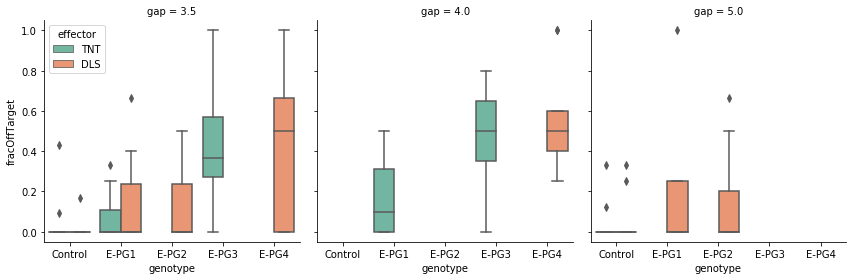

In [215]:
ax = sns.factorplot(kind='box',          # Boxplot
               y='fracOffTarget',   # Y-axis - values for boxplot
               x='genotype',        # X-axis - first factor
               hue='effector',      # Second factor denoted by color
               data=perFlyDatadf,   # Dataframe 
               size=4,              # Figure size (x100px)      
               aspect=1,          # Width = size * aspect 
               legend_out=False,
               palette='Set2',
               col='gap')

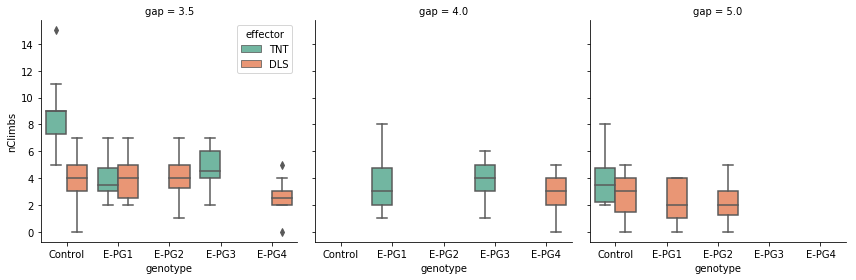

In [220]:
ax = sns.factorplot(kind='box', y='nClimbs', x='genotype', hue='effector', data=perFlyDatadf,
               size=4, aspect=1, legend_out=False, palette='Set2',col='gap')
#ax = sns.catplot(kind='swarm', y='nClimbs', x='genotype', hue='effector', data=perFlyDatadf,
#               size=4, aspect=1, legend_out=False, palette='Set2',col='gap')

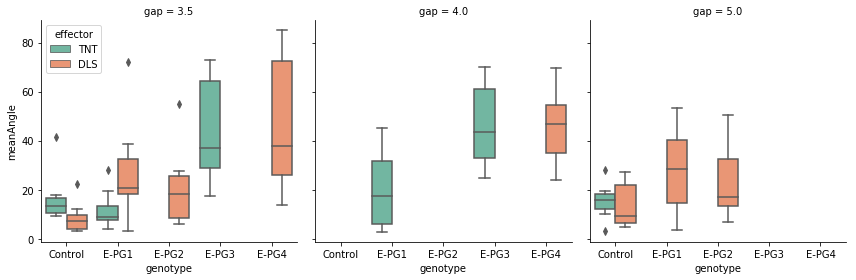

In [217]:
sns.factorplot(kind='box', y='meanAngle', x='genotype', hue='effector', data=perFlyDatadf,
               size=4, aspect=1, legend_out=False, palette='Set2',col='gap')

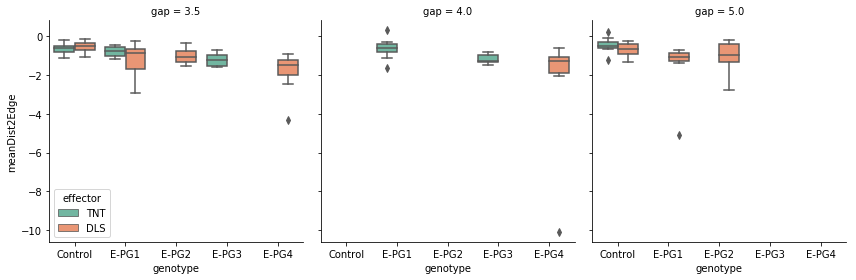

In [218]:
sns.factorplot(kind='box', y='meanDist2Edge', x='genotype', hue='effector', data=perFlyDatadf,
               size=4, aspect=1, legend_out=False, palette='Set2',col='gap')

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  exec(code_obj, self.user_global_ns, self.user_ns)


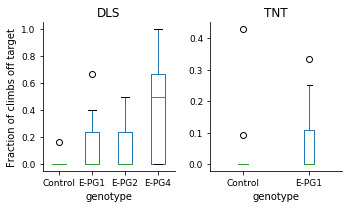

In [186]:
fig, axs = plt.subplots(1,2, figsize = (5,3))

perFlyDatadf.groupby('effector').boxplot(ax = axs, column = 'fracOffTarget', by='genotype', 
                                         fontsize=9, grid=False)
fig.suptitle('')
for ax in axs:
    myAxisTheme(ax)
axs[0].set_ylabel('Fraction of climbs off target')
fig.tight_layout()

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  exec(code_obj, self.user_global_ns, self.user_ns)


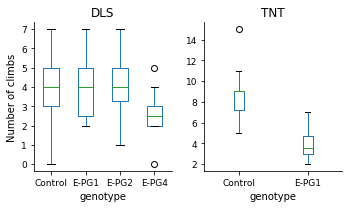

In [187]:
fig, axs = plt.subplots(1,2, figsize = (5,3))

perFlyDatadf.groupby('effector').boxplot(ax = axs, column = 'nClimbs', by='genotype',
                                         fontsize=9, grid=False)
fig.suptitle('')
for ax in axs:
    myAxisTheme(ax)
axs[0].set_ylabel('Number of climbs')
fig.tight_layout()

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  exec(code_obj, self.user_global_ns, self.user_ns)


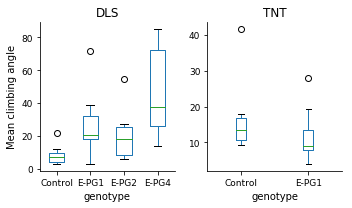

In [188]:
fig, axs = plt.subplots(1,2, figsize = (5,3))

perFlyDatadf.groupby('effector').boxplot(ax = axs, column = 'meanAngle', by='genotype', 
                                         fontsize=9, grid=False)
fig.suptitle('')
for ax in axs:
    myAxisTheme(ax)
axs[0].set_ylabel('Mean climbing angle')
fig.tight_layout()

/Users/haberkernh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2910: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes
  exec(code_obj, self.user_global_ns, self.user_ns)


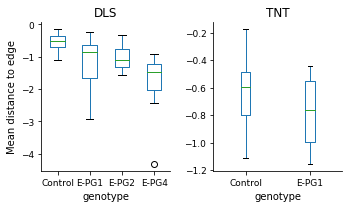

In [189]:
fig, axs = plt.subplots(1,2, figsize = (5,3))

perFlyDatadf.groupby('effector').boxplot(ax = axs, column = 'meanDist2Edge', by='genotype', 
                                         fontsize=9, grid=False)
fig.suptitle('')
for ax in axs:
    myAxisTheme(ax)
axs[0].set_ylabel('Mean distance to edge')
fig.tight_layout()